## Pre Processing;
1. Pre process file to trim start and end '"'
2. Impute missing column Description and Customer_ID
3. AmountSpent = Unit Price*Total Units

## Segmentation modeling
1. Customer segmentation with total units price and number of units purchased with K-means
2. Using RMF Analysis
3. doc2vec with product description & doc2vec with product description & country
4. Use Fast text or Bert for embed product description

In [2]:
import os
import re
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import util.pre_process as prep
import util.doc2vec_training as trn

import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
tf.logging.set_verbosity(tf.logging.ERROR)

%matplotlib inline

In [3]:
glob.glob('data/ML*.txt')

['data\\ML Data.txt', 'data\\ML Data_new.txt']

In [4]:
source_file = 'data\\ML Data.txt'
PATTERN = re.compile(r'''((?:[^,"]|"[^"]*"|'[^']*')+|(?=,,)|(?=,$)|(?=^,))''')

df = pd.read_csv(source_file, encoding='latin1')
cols = PATTERN.split(df.columns[0])[1::2]

df[cols] = pd.DataFrame(df.iloc[:,0].apply(lambda x: PATTERN.split(x)[1::2]).tolist(), index= df.index)
df.Invoice_Date = pd.to_datetime(df.Invoice_Date)
df.Quantity = pd.to_numeric(df.Quantity)
df.Unit_Price =  pd.to_numeric(df.Unit_Price)
df = df.drop(df.columns[0], axis=1)
print(df.shape)
print(df.columns)
display(df.head())

(541909, 8)
Index(['Invoice_Number', 'Product_Code', 'Description', 'Quantity',
       'Invoice_Date', 'Unit_Price', 'Customer_ID', 'Country'],
      dtype='object')


,Invoice_Number,Product_Code,Description,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [5]:
df.dtypes

Invoice_Number            object
Product_Code              object
Description               object
Quantity                   int64
Invoice_Date      datetime64[ns]
Unit_Price               float64
Customer_ID               object
Country                   object
dtype: object

In [6]:
df.describe(exclude=[np.number])

,Invoice_Number,Product_Code,Description,Invoice_Date,Customer_ID,Country
count,541909,541909,541909,541909,541909,541909
unique,25900,4070,4224,23260,4373,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2011-10-31 14:41:00,,United Kingdom
freq,1114,2313,2369,1114,135080,495478
first,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN
last,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN


In [7]:
df.describe(include=[np.number])

,Quantity,Unit_Price
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


### Check for duplicate & remove

In [8]:
df.drop_duplicates(inplace=True)
print(df.shape)

(536641, 8)


### Check for occurance of None

In [9]:
df.isna().sum()

Invoice_Number    0
Product_Code      0
Description       0
Quantity          0
Invoice_Date      0
Unit_Price        0
Customer_ID       0
Country           0
dtype: int64

### Univariate analysis of product quantity
1. Number of transaction vs cancellation
2. Number of transaction vs cancellation per country
3. Remove cancellation transaction

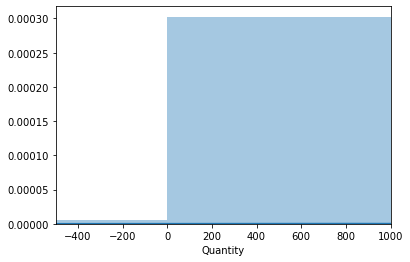

In [10]:
sns.distplot(df.Quantity)
plt.xlim(-500, 1000)
plt.show()

In [11]:
df['Cancellation'] = df.Quantity<0
df.loc[df.Cancellation==True].head()

,Invoice_Number,Product_Code,Description,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country,Cancellation
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom,True
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom,True
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,True
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,True
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,True


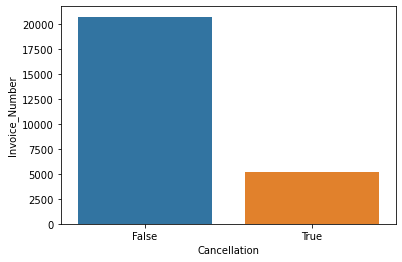

In [12]:
temp_df = df.groupby([df.Cancellation])['Invoice_Number'].nunique().reset_index()
sns.barplot(x='Cancellation',y='Invoice_Number', data=temp_df)

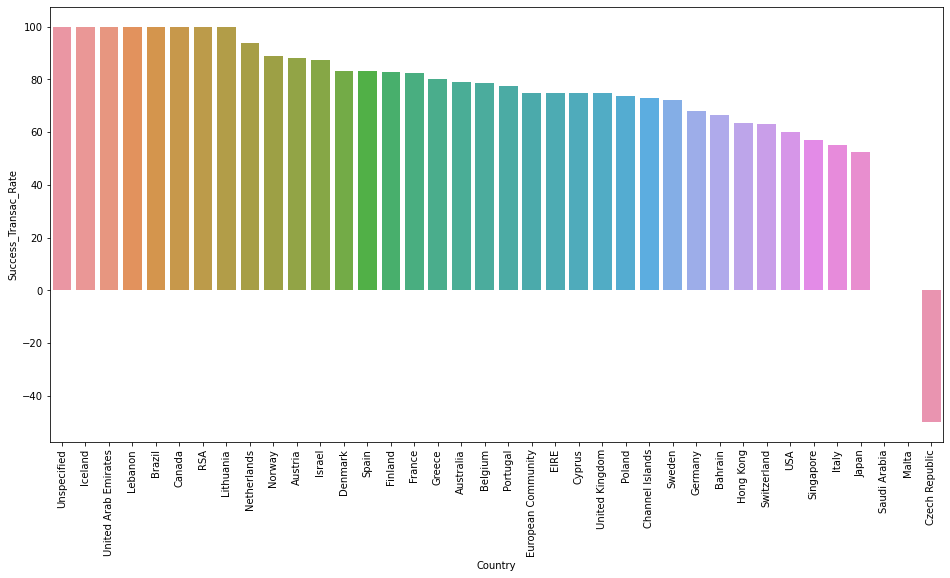

In [13]:
temp_df = df.groupby([df.Cancellation, df.Country])['Invoice_Number'].nunique().reset_index()

temp_df = temp_df.pivot(index='Country', columns='Cancellation', values='Invoice_Number')
temp_df.columns = temp_df.columns.map(lambda x: f'Cancellation_{x}')
temp_df = temp_df.reset_index()
temp_df = temp_df.fillna(0)
temp_df['Success_Transac_Rate'] = ((temp_df.Cancellation_False-temp_df.Cancellation_True)/temp_df.Cancellation_False)*100
plt.figure(figsize=(16, 8))
sns.barplot(x='Country',y='Success_Transac_Rate', data=temp_df, order=temp_df.sort_values('Success_Transac_Rate', ascending=False).Country)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

In [14]:
print(df.loc[df.Cancellation==True].shape)
df.loc[df.Cancellation==True].head()

(10587, 9)


,Invoice_Number,Product_Code,Description,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country,Cancellation
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom,True
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom,True
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,True
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,True
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,True


In [15]:
df = df.loc[df.Cancellation==False]
print(df.shape)

(526054, 9)


In [16]:
print(df.loc[df.Cancellation==True].shape)
df.loc[df.Cancellation==True].head()

(0, 9)


,Invoice_Number,Product_Code,Description,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country,Cancellation


### Univariate analysis Unit_Price
1. Removing negative Unit_Price records

In [17]:
df = df.loc[df.Unit_Price>0]
print(df.shape)

(524878, 9)


### Imputing missing product description: 
1. With multi product description replace product description with the most the occurrence description
2. Impute missing description for remaining blank product description

In [18]:
df.Description.isna().sum()

0

In [19]:
df.groupby(['Product_Code'])['Description'].nunique().sort_values(ascending=False)

Product_Code
23236     4
23196     4
17107D    3
22776     3
23366     3
         ..
46776B    1
46776A    1
46775D    1
46138B    1
10002     1
Name: Description, Length: 3922, dtype: int64

In [20]:
product_desc_mapping_df = pd.DataFrame(df.groupby(['Product_Code', 'Description'])['Invoice_Number'].nunique().reset_index()).sort_values(['Product_Code', 'Invoice_Number'], ascending=False).groupby('Product_Code').head(1).drop('Invoice_Number', axis=1)
product_desc_mapping_df.head()

,Product_Code,Description
4160,m,Manual
4159,gift_0001_50,Dotcomgiftshop Gift Voucher £50.00
4158,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00
4157,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00
4156,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00


In [21]:
df = pd.merge(df.drop('Description', axis=1), product_desc_mapping_df, how='outer')
df.loc[df.Description.isna(), 'Description'] = 'missing_description'

In [22]:
df.Description.isna().sum()

0

In [23]:
df.groupby(['Product_Code'])['Description'].nunique().sort_values(ascending=False)

Product_Code
m         1
22429     1
22427     1
22426     1
22425     1
         ..
44228     1
44092C    1
44092B    1
44091A    1
10002     1
Name: Description, Length: 3922, dtype: int64

## Imputing missing Customer_ID:
1. Checks to find if missing Customer_ID can be found with any matching invoice number.
2. Check if any particular country exhibits missing Customer_ID.
3. Impute missing customer id as unique customer as per their available transaction id

In [24]:
df.loc[df.Invoice_Number.isin(df.loc[df.Customer_ID.isna(), 'Invoice_Number'].unique())].Customer_ID.unique()

array([], dtype=object)

In [25]:
df.Country.value_counts()/len(df)

United Kingdom          0.914470
Germany                 0.017194
France                  0.015988
EIRE                    0.015011
Spain                   0.004723
Netherlands             0.004494
Belgium                 0.003869
Switzerland             0.003730
Portugal                0.002843
Australia               0.002250
Norway                  0.002040
Italy                   0.001444
Channel Islands         0.001423
Finland                 0.001305
Cyprus                  0.001149
Sweden                  0.000857
Unspecified             0.000842
Austria                 0.000758
Denmark                 0.000724
Poland                  0.000629
Japan                   0.000612
Israel                  0.000556
Hong Kong               0.000533
Singapore               0.000423
Iceland                 0.000347
USA                     0.000341
Canada                  0.000288
Greece                  0.000276
Malta                   0.000213
United Arab Emirates    0.000130
European C

In [26]:
df.loc[df.Customer_ID.isna(), 'Country'].value_counts()/len(df.Customer_ID.isna())

Series([], Name: Country, dtype: float64)

In [28]:
df.loc[((df.Customer_ID=='') | (df.Customer_ID.isna())), 'Customer_ID'] = 'missing_cust_id_'+df.loc[df.Customer_ID.isna(), 'Invoice_Number']
df.iloc[12:16, :]

,Invoice_Number,Product_Code,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country,Cancellation,Description
12,536575,85123A,128,2010-12-01 16:01:00,2.55,13777,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
13,536576,85123A,128,2010-12-01 16:11:00,2.55,13777,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
14,536590,85123A,6,2010-12-01 16:52:00,2.95,13065,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
15,536592,85123A,9,2010-12-01 17:06:00,5.91,NaN,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER


#### Doc2vec with user all Product_Code

In [29]:
temp_df = df.copy()
display(temp_df.head())

,Invoice_Number,Product_Code,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country,Cancellation,Description
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
1,536373,85123A,6,2010-12-01 09:02:00,2.55,17850,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
2,536375,85123A,6,2010-12-01 09:32:00,2.55,17850,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
3,536390,85123A,64,2010-12-01 10:19:00,2.55,17511,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
4,536394,85123A,32,2010-12-01 10:39:00,2.55,13408,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER


In [30]:
product_code_2_description_map_dict = {}
product_code_2_description_map = pd.DataFrame(temp_df.groupby(['Product_Code'])['Description'].unique()).reset_index()
product_code_2_description_map['Description'] = product_code_2_description_map['Description'].apply(lambda x: x[0])
for index, row in product_code_2_description_map.iterrows():
    product_code_2_description_map_dict[row['Product_Code']] =  row['Description']
print(len(product_code_2_description_map_dict))
print(product_code_2_description_map.shape)
product_code_2_description_map.head()

3922
(3922, 2)


,Product_Code,Description
0,10002,INFLATABLE POLITICAL GLOBE
1,10080,GROOVY CACTUS INFLATABLE
2,10120,DOGGY RUBBER
3,10123C,HEARTS WRAPPING TAPE
4,10124A,SPOTS ON RED BOOKCOVER TAPE


In [31]:
selected_Customer_ID = list(temp_df.groupby(['Customer_ID'])['Product_Code'].nunique().loc[temp_df.groupby(['Customer_ID'])['Product_Code'].nunique()>5].index)
len(selected_Customer_ID)

4008

In [32]:
temp_df = temp_df.loc[temp_df.Customer_ID.isin(selected_Customer_ID)]
temp_df = pd.DataFrame(temp_df.groupby('Customer_ID')['Product_Code'].unique()).reset_index()
temp_df['static_user_profile_list'] = temp_df.Product_Code
model_data = temp_df
temp_df.head()

,Customer_ID,Product_Code,static_user_profile_list
0,12347,"[84969, 22728, 22727, 22726, 21791, 21035, 217...","[84969, 22728, 22727, 22726, 21791, 21035, 217..."
1,12348,"[POST, 21977, 84991, 21980, 21213, 84992, 2295...","[POST, 21977, 84991, 21980, 21213, 84992, 2295..."
2,12349,"[22960, 22326, POST, 21533, 21411, 85014B, 850...","[22960, 22326, POST, 21533, 21411, 85014B, 850..."
3,12350,"[POST, 21832, 21915, 22620, 21866, 22557, 2255...","[POST, 21832, 21915, 22620, 21866, 22557, 2255..."
4,12352,"[21754, 21755, 21756, 21731, POST, 22646, 2278...","[21754, 21755, 21756, 21731, POST, 22646, 2278..."


In [33]:
model_dir = 'model_pc'
model = trn.training(temp_df, True, model_dir, epochs=30)    

if model_data.shape[0] != len(model.docvecs.vectors_docs):
    print('error')

train_corpus[0]:TaggedDocument(['84969' '22728' '22727' '22726' '21791' '21035' '21731' '22492' '84997B'
 '84997C' '21975' '84991' '22774' '22771' '47580' '21832' '22195' '22196'
 '22729' '20966' '84625C' '84625A' '22772' '22773' '22805' '22417' '84992'
 '22371' '85116' '22775' '21976' '21154' '17021' '22945' '22423' '84558A'
 '22376' '22372' '84997D' '21041' '22699' '22697' '22561' '22494' '22134'
 '22375' '22422' '22432' '22497' '22550' '47559B' '85178' '20719' '22212'
 '51014C' '22725' '71477' '20780' '47567B' '84559A' '84559B' '85232D'
 '20665' '22131' '22374' '21064' '22821' '21578' '22621' '85167B' '22252'
 '20782' '21265' '21171' '22698' '16008' '21636' '22992' '23177' '23076'
 '23146' '23147' '23162' '23175' '23174' '23173' '23172' '23171' '23170'
 '23084' '23308' '23271' '23316' '23297' '23422' '23421' '23420' '23503'
 '23506' '23508' '23480' '23497' '23552'], ['12347'])
epochs:30, window:4, vector_size:64, ns_exponent:0.254610887, min_count:4
model training
Model Saved at: mo

In [34]:
projection_dir = 'projections_pc'
if not os.path.exists(projection_dir):
    os.makedirs(projection_dir)
    
with open(f"{projection_dir}/metadata.tsv", 'w+') as file_metadata:
    for i in list(model.docvecs.doctags.keys()):
        file_metadata.write(i + '\n')

In [35]:
sess = tf.InteractiveSession()
d2v = model.docvecs.vectors_docs
with tf.device("/cpu:0"):
    embedding = tf.Variable(d2v, trainable=False, name='embedding')
tf.global_variables_initializer().run()
saver = tf.train.Saver()
writer = tf.summary.FileWriter('projections', sess.graph)
config = projector.ProjectorConfig()
embed= config.embeddings.add()
embed.tensor_name = 'embedding'
embed.metadata_path = 'metadata.tsv'

projector.visualize_embeddings(writer, config)

saver.save(sess, 'projections/model.ckpt', global_step=len(d2v))

'projections/model.ckpt-4008'

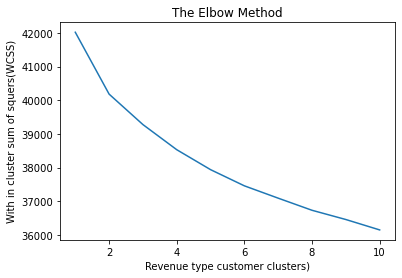

In [38]:
with_in_cluster_sum_squares_list = [] 

for i in range(1,11): #From 2-10 doing multiple random initializations can make a huge difference to find a better local optima
    kmeans = KMeans(n_clusters = i, init ='k-means++',max_iter=300,n_init=10)
    kmeans.fit(d2v)
    with_in_cluster_sum_squares_list.append(kmeans.inertia_)

sns.lineplot(x=range(1,11), y= with_in_cluster_sum_squares_list)
plt.title('The Elbow Method')
plt.xlabel('Revenue type customer clusters)')
plt.ylabel('With in cluster sum of squers(WCSS)')
plt.show()

In [41]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++')
kmeans.fit(d2v)
model_data['Doc2vec_Cluster'] = kmeans.predict(d2v)

print(model_data.Doc2vec_Cluster.nunique())

model_data.head()

5


,Customer_ID,Product_Code,static_user_profile_list,Doc2vec_Cluster
0,12347,"[84969, 22728, 22727, 22726, 21791, 21035, 217...","[84969, 22728, 22727, 22726, 21791, 21035, 217...",2
1,12348,"[POST, 21977, 84991, 21980, 21213, 84992, 2295...","[POST, 21977, 84991, 21980, 21213, 84992, 2295...",4
2,12349,"[22960, 22326, POST, 21533, 21411, 85014B, 850...","[22960, 22326, POST, 21533, 21411, 85014B, 850...",3
3,12350,"[POST, 21832, 21915, 22620, 21866, 22557, 2255...","[POST, 21832, 21915, 22620, 21866, 22557, 2255...",2
4,12352,"[21754, 21755, 21756, 21731, POST, 22646, 2278...","[21754, 21755, 21756, 21731, POST, 22646, 2278...",0


In [42]:
for i in range(5):
    print('*'*10)
    print(i)
    print('*'*10)
    for i, v in model_data.loc[model_data.Doc2vec_Cluster==i, ['Product_Code', 'static_user_profile_list']].head(2).iterrows():
        print([product_code_2_description_map_dict[i] for i in v['static_user_profile_list']])
        print('-'*10)

**********
0
**********
['HOME BUILDING BLOCK WORD', 'LOVE BUILDING BLOCK WORD', 'BATH BUILDING BLOCK WORD', 'RED TOADSTOOL LED NIGHT LIGHT', 'POSTAGE', 'CERAMIC STRAWBERRY CAKE MONEY BANK', 'LIGHT GARLAND BUTTERFILES PINK', 'WOODEN OWLS LIGHT GARLAND ', 'DELUXE SEWING KIT ', 'SMALL GLASS HEART TRINKET POT', 'STRAWBERRY CERAMIC TRINKET BOX', 'PINK DOUGHNUT TRINKET POT ', 'SET OF 4 ENGLISH ROSE COASTERS', 'METAL SIGN TAKE IT OR LEAVE IT ', 'BLUE HARMONICA IN BOX ', 'VICTORIAN GLASS HANGING T-LIGHT', 'DOLLY GIRL LUNCH BOX', 'CERAMIC HEART FAIRY CAKE MONEY BANK', 'REGENCY CAKESTAND 3 TIER', 'LANTERN CREAM GAZEBO ', 'IVORY KITCHEN SCALES', 'CHILDS BREAKFAST SET DOLLY GIRL ', 'CHILDS BREAKFAST SET SPACEBOY ', 'MINT KITCHEN SCALES', 'WELCOME  WOODEN BLOCK LETTERS', 'PINK HEART SHAPE EGG FRYING PAN', 'ANTIQUE GLASS PEDESTAL BOWL', 'FAIRY CAKE BIRTHDAY CANDLE SET', 'HOLIDAY FUN LUDO', 'VINTAGE CREAM DOG FOOD CONTAINER', 'Manual', 'CERAMIC CAKE DESIGN SPOTTED MUG', 'BIG DOUGHNUT FRIDGE MAGNETS'

#### Doc2vec with user top_10 Product_Code

In [39]:
temp_df = df.copy()
display(temp_df.head())

,Invoice_Number,Product_Code,Quantity,Invoice_Date,Unit_Price,Customer_ID,Country,Cancellation,Description
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
1,536373,85123A,6,2010-12-01 09:02:00,2.55,17850,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
2,536375,85123A,6,2010-12-01 09:32:00,2.55,17850,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
3,536390,85123A,64,2010-12-01 10:19:00,2.55,17511,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER
4,536394,85123A,32,2010-12-01 10:39:00,2.55,13408,United Kingdom,False,WHITE HANGING HEART T-LIGHT HOLDER


In [40]:
temp_df = temp_df.loc[temp_df.Customer_ID.isin(selected_Customer_ID)]
temp_df = pd.DataFrame(temp_df.groupby(['Customer_ID', 'Product_Code'])['Product_Code'].count()).rename({'Product_Code':'n_count'}, axis=1).reset_index().sort_values(['Customer_ID', 'n_count'], ascending=False).groupby(['Customer_ID']).head(10)# temp_df = pd.DataFrame(temp_df.groupby('Customer_ID')['Product_Code'].unique()).reset_index()
temp_df = pd.DataFrame(temp_df.groupby('Customer_ID')['Product_Code'].unique()).reset_index()
temp_df['static_user_profile_list'] = temp_df.Product_Code
model_data = temp_df
temp_df.head()

,Customer_ID,Product_Code,static_user_profile_list
0,12347,"[22375, 21731, 22727, 84558A, 20719, 22196, 22...","[22375, 21731, 22727, 84558A, 20719, 22196, 22..."
1,12348,"[POST, 21213, 21977, 22952, 23077, 23078, 8499...","[POST, 21213, 21977, 22952, 23077, 23078, 8499..."
2,12349,"[20685, 20914, 21086, 21136, 21231, 21232, 214...","[20685, 20914, 21086, 21136, 21231, 21232, 214..."
3,12350,"[20615, 20652, 21171, 21832, 21864, 21866, 219...","[20615, 20652, 21171, 21832, 21864, 21866, 219..."
4,12352,"[POST, 22779, 22780, 84050, M, 21755, 21756, 2...","[POST, 22779, 22780, 84050, M, 21755, 21756, 2..."


In [41]:
model_dir = 'model_pc'
model = trn.training(temp_df, True, model_dir, epochs=30)    

if model_data.shape[0] != len(model.docvecs.vectors_docs):
    print('error')

train_corpus[0]:TaggedDocument(['22375' '21731' '22727' '84558A' '20719' '22196' '22371' '22423' '22725'
 '21791'], ['12347'])
epochs:30, window:4, vector_size:64, ns_exponent:0.254610887, min_count:4
model training
Model Saved at: model_pc/model_dm0_vector_size64_min_count4_epochs30_window4_ns_exponent0.254610887_alpha0.016691564_min_alpha0.000591644_hs1_seed1234.model
n_correct_prediction: [0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


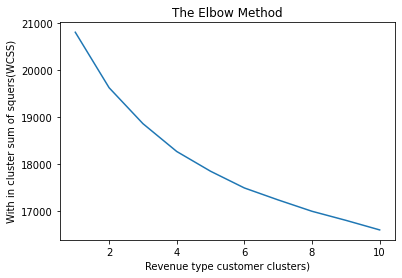

In [44]:
d2v = model.docvecs.vectors_docs

with_in_cluster_sum_squares_list = [] 

for i in range(1,11): #From 2-10 doing multiple random initializations can make a huge difference to find a better local optima
    kmeans = KMeans(n_clusters = i, init ='k-means++',max_iter=300,n_init=10)
    kmeans.fit(d2v)
    with_in_cluster_sum_squares_list.append(kmeans.inertia_)

sns.lineplot(x=range(1,11), y= with_in_cluster_sum_squares_list)
plt.title('The Elbow Method')
plt.xlabel('Revenue type customer clusters)')
plt.ylabel('With in cluster sum of squers(WCSS)')
plt.show()

In [45]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++')
kmeans.fit(d2v)
model_data['Doc2vec_Cluster'] = kmeans.predict(d2v)

print(model_data.Doc2vec_Cluster.nunique())

model_data.head()

5


,Customer_ID,Product_Code,static_user_profile_list,Doc2vec_Cluster
0,12347,"[22375, 21731, 22727, 84558A, 20719, 22196, 22...","[22375, 21731, 22727, 84558A, 20719, 22196, 22...",1
1,12348,"[POST, 21213, 21977, 22952, 23077, 23078, 8499...","[POST, 21213, 21977, 22952, 23077, 23078, 8499...",2
2,12349,"[20685, 20914, 21086, 21136, 21231, 21232, 214...","[20685, 20914, 21086, 21136, 21231, 21232, 214...",2
3,12350,"[20615, 20652, 21171, 21832, 21864, 21866, 219...","[20615, 20652, 21171, 21832, 21864, 21866, 219...",2
4,12352,"[POST, 22779, 22780, 84050, M, 21755, 21756, 2...","[POST, 22779, 22780, 84050, M, 21755, 21756, 2...",4


In [46]:
for i in range(5):
    print('*'*10)
    print(i)
    print('*'*10)
    for i, v in model_data.loc[model_data.Doc2vec_Cluster==i, ['Product_Code', 'static_user_profile_list']].head(2).iterrows():
        print([product_code_2_description_map_dict[i] for i in v['static_user_profile_list']])
        print('-'*10)

**********
0
**********
['PORCELAIN ROSE LARGE ', 'PORCELAIN ROSE SMALL', 'PHARMACIE FIRST AID TIN', 'SET OF 2 ROUND TINS CAMEMBERT ', 'PLASTERS IN TIN STRONGMAN', 'PLASTERS IN TIN VINTAGE PAISLEY ', '20 DOLLY PEGS RETROSPOT', 'ASSORTED BOTTLE TOP  MAGNETS ', 'IVORY GIANT GARDEN THERMOMETER', 'BIRTHDAY PARTY CORDON BARRIER TAPE']
----------
['PARTY BUNTING', 'SET OF 3 CAKE TINS PANTRY DESIGN ', 'PINK HAPPY BIRTHDAY BUNTING', 'HANGING HEART JAR T-LIGHT HOLDER', "PAPER CHAIN KIT 50'S CHRISTMAS ", 'FELT EGG COSY CHICKEN', 'IVORY KNITTED MUG COSY ', 'RED BABY BUNTING ', 'PAPER CHAIN KIT VINTAGE CHRISTMAS', 'SINGLE HEART ZINC T-LIGHT HOLDER']
----------
**********
1
**********
['AIRLINE BAG VINTAGE JET SET BROWN', 'RED TOADSTOOL LED NIGHT LIGHT', 'ALARM CLOCK BAKELIKE RED ', '3D DOG PICTURE PLAYING CARDS', 'WOODLAND CHARLOTTE BAG', 'SMALL HEART MEASURING SPOONS', 'AIRLINE BAG VINTAGE TOKYO 78', 'REGENCY CAKESTAND 3 TIER', 'ALARM CLOCK BAKELIKE CHOCOLATE', 'VINTAGE HEADS AND TAILS CARD GAME 